In [105]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [106]:
class Creature(Agent):
    def __init__(self, unique_id, model, trait=None, mutation_rate=0.01):
        super().__init__(unique_id, model)
        self.trait = trait if trait is not None else {"Trait1": model.random.random(),
                                                      "Trait2": model.random.random(),
                                                      "Trait3": model.random.random()}
        self.environment_factor = model.environment_factor
        self.mutation_rate = mutation_rate

    def step(self):
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        neighbor_traits = [neighbor.trait for neighbor in neighbors]
    
        avg_neighbor_traits = {key: np.mean([t[key] for t in neighbor_traits]) for key in self.trait.keys()} if neighbors else self.trait
    
        trait_difference = {key: avg_neighbor_traits[key] - self.trait[key] for key in self.trait.keys()}

    # Update traits based on a small fraction of the trait difference, environmental factor, and mutation rate
        for key in self.trait.keys():
            # Adaptive behavior: Adjust traits based on environment and neighbors
            self.trait[key] += self.model.selection_pressure * 0.1 * trait_difference[key] * self.environment_factor
    
            # Introduce mutation: Randomly change one of the trait values with a certain probability (mutation rate)
            if self.model.random.random() < self.mutation_rate:
                self.trait[key] += self.model.random.normalvariate(0, 0.1)  # You can adjust the mutation magnitude
    
                # Ensure trait values stay within the range [0, 1]
                self.trait[key] = max(0, min(1, self.trait[key]))


In [107]:
class EvolutionModel(Model):
    def __init__(self, N, width, height, environment_factor, mutation_rate, selection_pressure, initial_traits=None):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.environment_factor = environment_factor
        self.mutation_rate = mutation_rate
        self.selection_pressure = selection_pressure


        # If initial traits are provided, each agent is assigned one of the predefined traits
        if initial_traits:
            for i in range(self.num_agents):
                agent_trait = initial_traits[i % len(initial_traits)]
                agent = Creature(i, self, trait=agent_trait, mutation_rate=mutation_rate)
                x = np.random.choice(self.grid.width)
                y = np.random.choice(self.grid.height)
                self.grid.place_agent(agent, (x, y))
                self.schedule.add(agent)
        else:
            # If no initial traits are provided, create agents with random traits
            for i in range(self.num_agents):
                agent = Creature(i, self, mutation_rate=mutation_rate)
                x = np.random.choice(self.grid.width)
                y = np.random.choice(self.grid.height)
                self.grid.place_agent(agent, (x, y))
                self.schedule.add(agent)

        self.datacollector = DataCollector(agent_reporters={"x": lambda a: a.pos[0], 
                                                            "y": lambda a: a.pos[1], 
                                                            "Trait1": lambda a: a.trait["Trait1"], 
                                                            "Trait2": lambda a: a.trait["Trait2"], 
                                                            "Trait3": lambda a: a.trait["Trait3"], 
                                                            "Environment Factor": "environment_factor"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [108]:
# Run the model for a certain number of steps
user_defined_environment_factor = 1
user_defined_mutation_rate = 0.5
user_defined_initial_traits = {"Trait1": 0.8, "Trait2": 0.1, "Trait3": 0.4}
user_defined_selection_pressure = 0.5
N_steps = 200 # Increase this to get a longer time series
N_agents = 300
width = 50
height = 50

model = EvolutionModel(N_agents, width, height, user_defined_environment_factor, user_defined_mutation_rate, user_defined_selection_pressure)
for i in range(N_steps):
    model.step()
# print(f"Number of steps in the model: {model.schedule.steps}")
# Extract and visualize data collected during the simulation
agent_data = model.datacollector.get_agent_vars_dataframe()
# print(f"Number of rows in agent_data: {len(agent_data)}")
# print(agent_data)
# Get data for the last step
last_step_data = agent_data.xs(N_steps-1, level="Step")

# Unstack the data for plotting
unstacked_data = last_step_data.unstack()

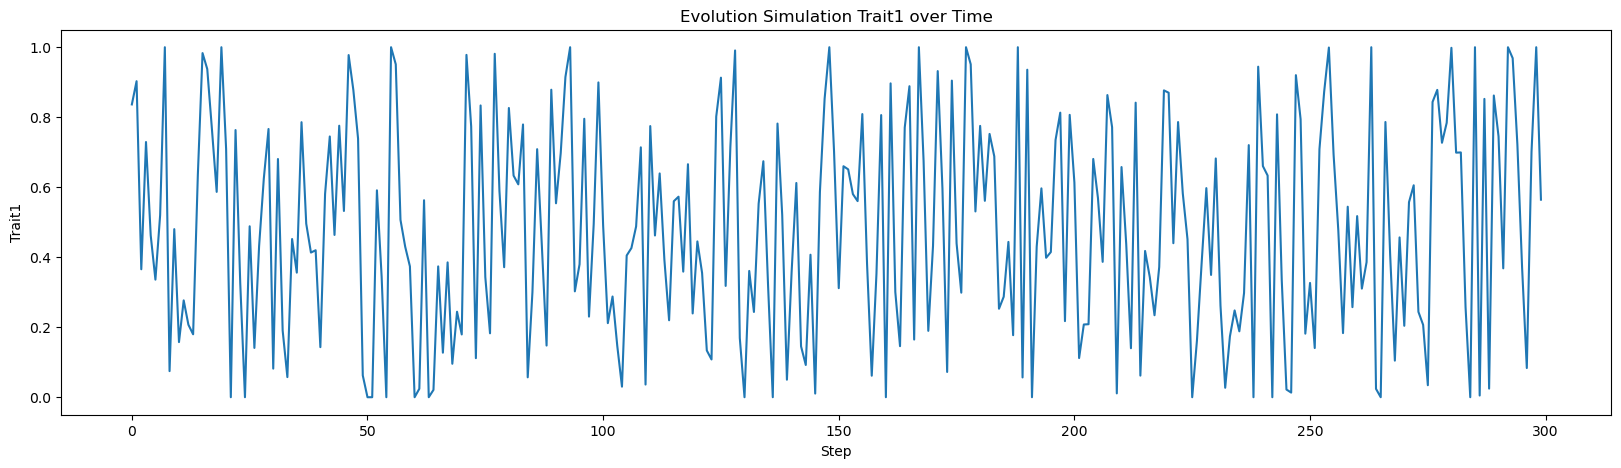

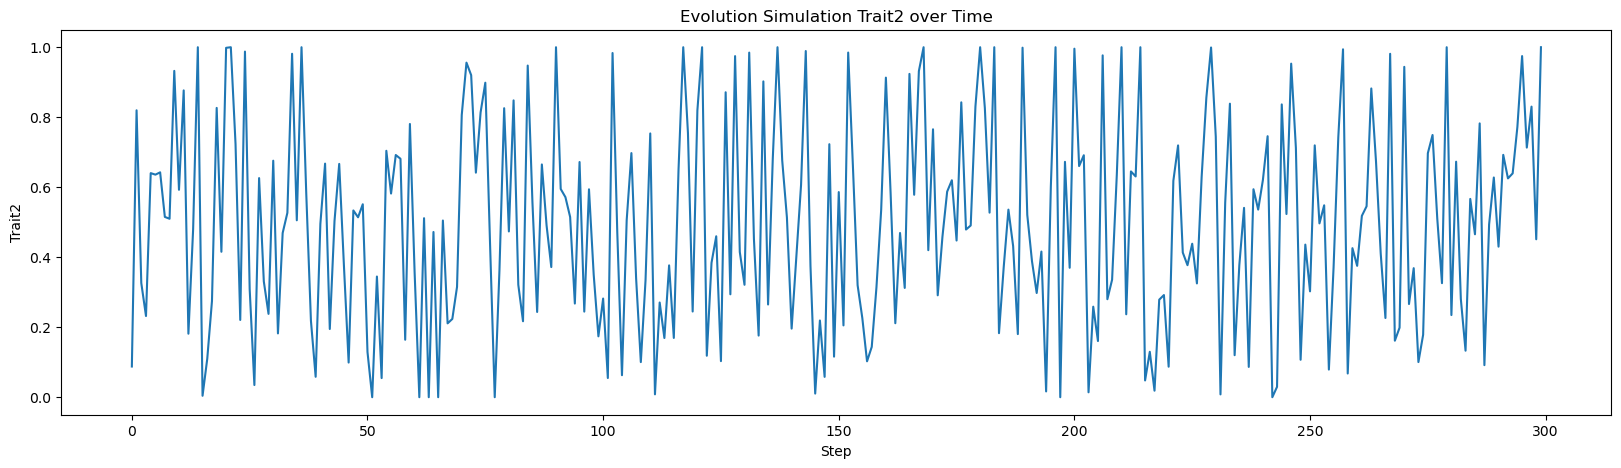

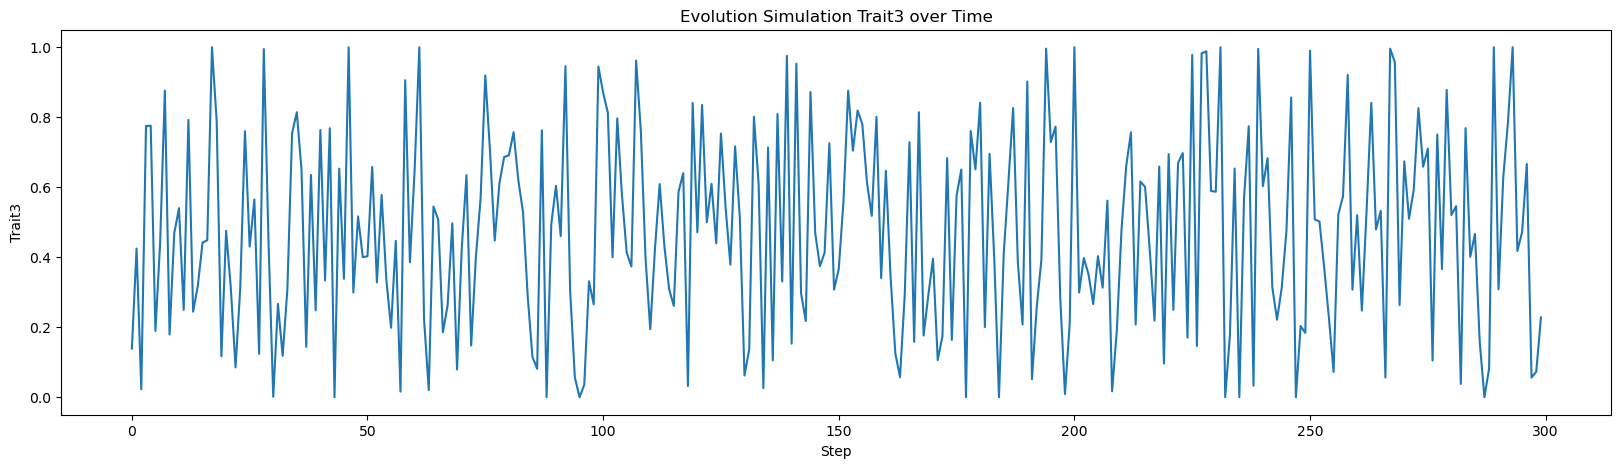

In [109]:
# Plot each trait separately
for trait in ["Trait1", "Trait2", "Trait3"]:
    plt.figure(figsize=(20, 5))
    unstacked_data[trait].plot()
    plt.xlabel('Step')
    plt.ylabel(trait)
    plt.title(f'Evolution Simulation {trait} over Time')
    # plt.show()

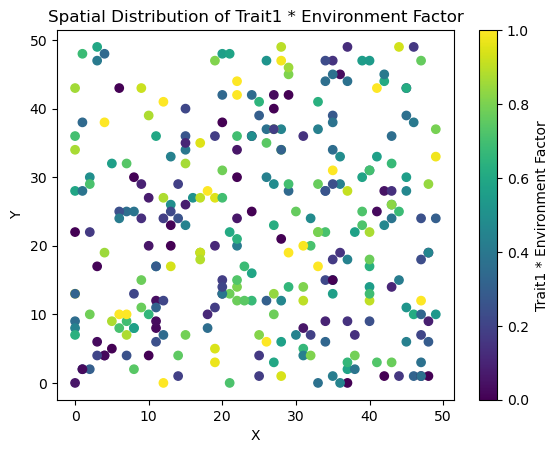

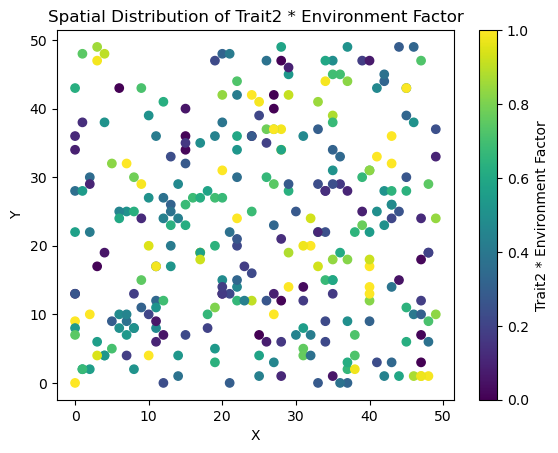

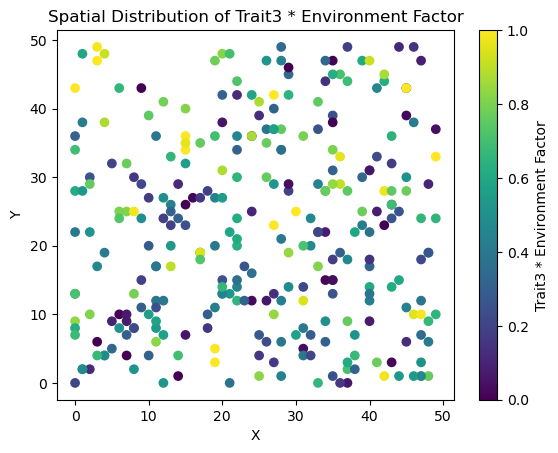

In [110]:
# Visualize the spatial distribution of traits and environmental factors in the last step
for trait in ["Trait1", "Trait2", "Trait3"]:
    fig, ax = plt.subplots()
    sc = ax.scatter(last_step_data["x"], last_step_data["y"],c=last_step_data[trait].values * last_step_data["Environment Factor"].values,cmap='viridis')
    plt.colorbar(sc, label=f'{trait} * Environment Factor')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Spatial Distribution of {trait} * Environment Factor')
    plt.show()

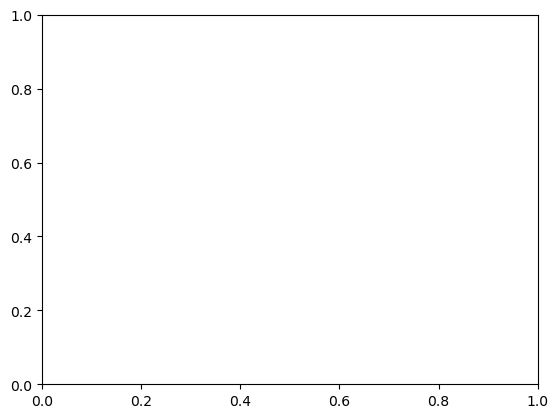

In [111]:
# Function to update the plot
fig, ax = plt.subplots()
def update(i):
    print(i)
    fig.clear()
    step_data = agent_data.xs(i, level="Step")

    ax = fig.add_subplot(111)
    sc_local = ax.scatter(step_data["x"], step_data["y"], c=step_data[f"Trait3"].values * step_data["Environment Factor"].values, cmap='viridis')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Spatial Distribution Step {i} trait 3')
    sc_local.set_offsets(np.column_stack((step_data["y"], step_data["x"])))
    cbar = fig.colorbar(sc_local, ax=ax, label = f'Trait 3 * Environment Factor')
    
    

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


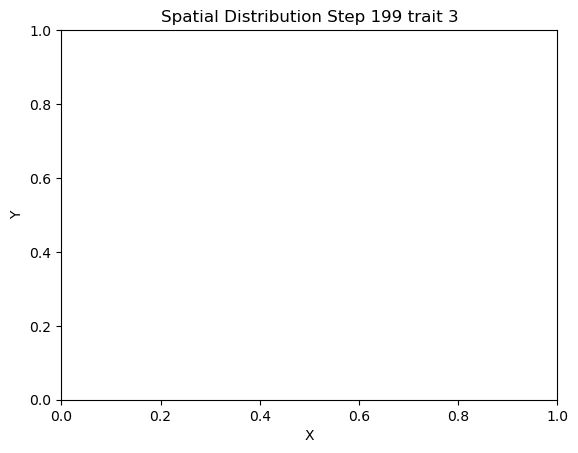

In [112]:
# Create an animation
ani = FuncAnimation(fig, update, frames = N_steps, repeat=True)

# Save the animation as a video file
ani.save('trait3.mp4', writer='ffmpeg')